## Compute the Revenues

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date

raw_train_data = pd.read_csv("./train.csv")
raw_test_data = pd.read_csv("./test.csv")
train_data = raw_train_data.copy()

# extract some informations that are useful to compute revenue
adr_df = raw_train_data[['arrival_date_year', 
                         'arrival_date_month',
                         'arrival_date_day_of_month',
                         'adr', 
                         'stays_in_weekend_nights',
                         'stays_in_week_nights',
                         'is_canceled',
                         'deposit_type']].copy()
# month names converted to the numbers
adr_df['arrival_date_month'].replace({'January' : '1',
        'February' : '2',
        'March' : '3',
        'April' : '4',
        'May' : '5',
        'June' : '6',
        'July' : '7',
        'August' : '8',
        'September' : '9', 
        'October' : '10',
        'November' : '11',
        'December' : '12'}, inplace=True)
adr_df['arrival_date'] = "" # format: y-m-d

def combine_to_date(row):
    # year, month, day -> y-m-d
    return str(row['arrival_date_year']) + "-" \
    + str(row['arrival_date_month']) + "-" \
    + str(row['arrival_date_day_of_month'])

def stay_nights_sum(row):
    return row['stays_in_weekend_nights'] + row['stays_in_week_nights']

# additional informations
adr_df['arrival_date'] = adr_df.apply(combine_to_date, axis=1)
adr_df['tm_yday'] = adr_df['arrival_date'].apply(lambda input_date: datetime.strptime(input_date,"%Y-%m-%d").timetuple().tm_yday)
adr_df['tm_wday'] = adr_df['arrival_date'].apply(lambda input_date: datetime.strptime(input_date,"%Y-%m-%d").timetuple().tm_wday)
adr_df['stay_nights'] = adr_df.apply(stay_nights_sum, axis=1)


# compute the revenue
# this dataframe is used to store the revenue for each day
revenue_df = pd.DataFrame(columns=['date', 'revenue', 'year', 'month', 'month_day'])

REFUND_RATIO = 1
def compute_single_venue(row):
    adr = row['adr']
    deposit_type = row['deposit_type']
    nights = row['stay_nights']
    is_canceled = row['is_canceled']
    if not is_canceled:
        return adr * nights
    else:
        if deposit_type == "Non Refund":
            return adr * nights * REFUND_RATIO
        else:
            return 0
revenue_df = pd.DataFrame(columns=['arrival_date', 'revenue', 'year', 'month', 'month_day', 'tm_yday'])
revenue_df.set_index = revenue_df['arrival_date']
for index, row in adr_df.iterrows():
    if row['arrival_date'] not in revenue_df.index.values:
        # create the new row
        new_row = pd.DataFrame()
        new_row['arrival_date'] = [row['arrival_date']]
        new_row['revenue'] = [compute_single_venue(row)]
        new_row['year'] = [row['arrival_date_year']]
        new_row['month'] = [row['arrival_date_month']]
        new_row['month_day'] = [row['arrival_date_day_of_month']]
        new_row['tm_yday'] = new_row['arrival_date'].apply(lambda input_date: datetime.strptime(input_date,"%Y-%m-%d").timetuple().tm_yday)
        # append the row into the revenue dataframe
        new_row.index = new_row['arrival_date']
        revenue_df = pd.concat([revenue_df, new_row])
    else:
        revenue_df.loc[row['arrival_date'], 'revenue'] += [compute_single_venue(row)]

## Compare Revenues with Labels

Take year 2016 (has revenue and label for each day) for example:

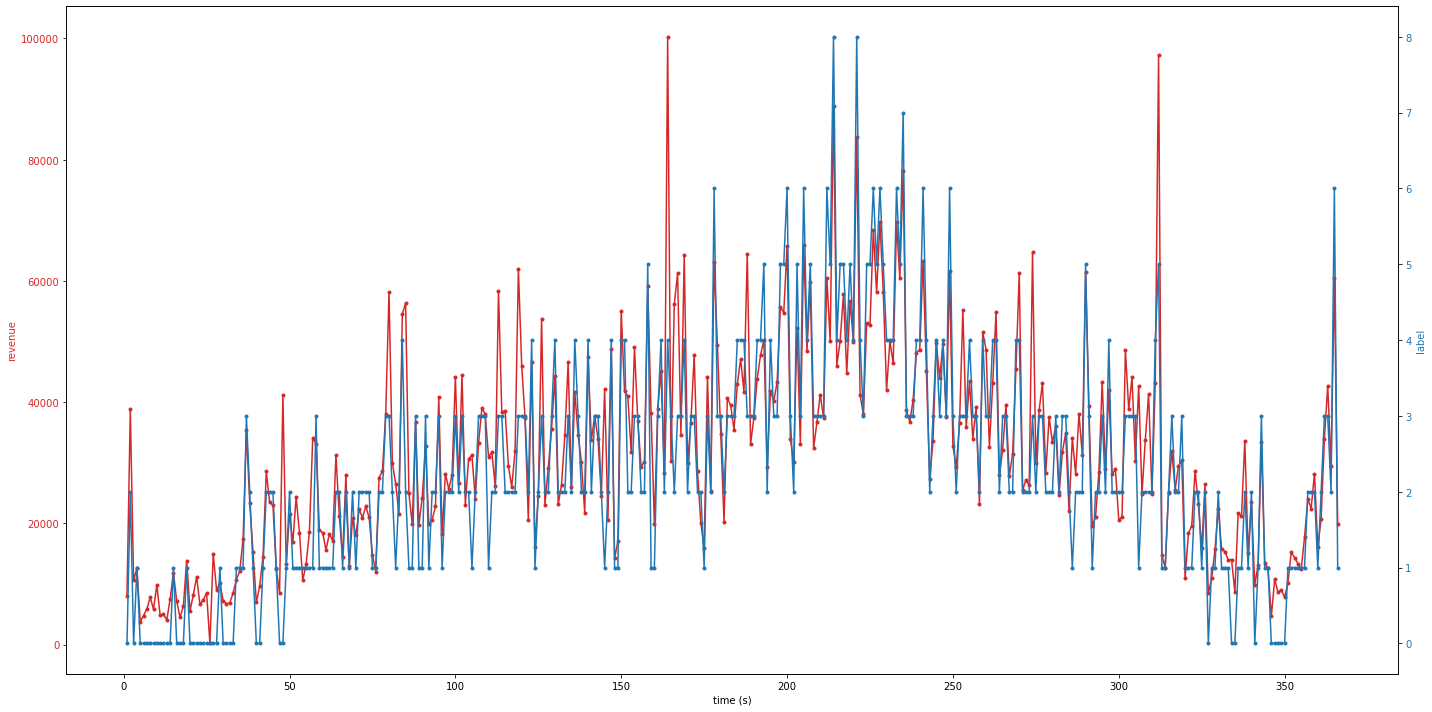

In [7]:
label_data = pd.read_csv("train_label.csv")

def date_to_numbers(date):
    # return year, month, date
    year, month, date = [int(word) for word in date.split('-')]
    return year, month, date

# add additional columns for plotting
label_data['year'] = 0
label_data['month'] = 0
label_data['month_day'] = 0
label_data[['year', 'month', 'month_day']] = [attr for attr in label_data["arrival_date"].apply(date_to_numbers)]
label_data['tm_yday'] = label_data['arrival_date'].apply(lambda input_date: datetime.strptime(input_date,"%Y-%m-%d").timetuple().tm_yday)
label_data['tm_wday'] = label_data['arrival_date'].apply(lambda input_date: datetime.strptime(input_date,"%Y-%m-%d").timetuple().tm_wday)
fig, ax1 = plt.subplots(figsize=(20, 10))

year_2016_idx = revenue_df['year'] == 2016
year_2016_revenue = revenue_df[year_2016_idx].sort_values(by='tm_yday')
year_2016_idx = label_data['year'] == 2016
year_2016_label = label_data[year_2016_idx].sort_values(by='tm_yday')

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('revenue', color=color)
ax1.plot(year_2016_revenue['tm_yday'], year_2016_revenue['revenue'], '.-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('label', color=color)  # we already handled the x-label with ax1
ax2.plot(year_2016_label['tm_yday'], year_2016_label['label'],'.-' ,color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()